# Basic RNA circuit simulation 



In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from bioreaction.simulation.basic_sim import convert_model

import jax
import numpy as np
import pandas as pd
import os
import sys

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-paper')
os.environ["TF_CPP_MIN_LOG_LOVEL"] = "0"
jax.config.update('jax_platform_name', 'gpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.utils.data.data_format_tools.common import load_json_as_dict
from src.utils.common.setup_new import prepare_config, construct_circuit_from_cfg
from src.utils.circuit.agnostic_circuits.circuit_manager_new import CircuitModeller
from src.utils.evolution.evolver import load_mutations
from src.utils.misc.type_handling import flatten_listlike
from src.utils.modelling.physical import equilibrium_constant_reparameterisation
from tests_local.shared import five_circuits

config = load_json_as_dict('../tests_local/configs/simple_circuit.json')


In [58]:



def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else: # unbound RNA -> bound RNA
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
    return model


def make_params(model, scale_rates=True):
    sim_model = convert_model(model)

    if scale_rates:
        m = np.max([sim_model.forward_rates.max(), sim_model.reverse_rates.max()])
    else:
        m = 1
    inputs = sim_model.inputs
    outputs = sim_model.outputs
    forward_rates = sim_model.forward_rates/m
    reverse_rates = sim_model.reverse_rates/m
    return inputs, outputs, forward_rates, reverse_rates, m

Use the 5 tester circuits :)

In [59]:
config = prepare_config(config)
config['include_prod_deg'] = False
config['simulation']['use_rate_scaling'] = False

q = 1
p = 1
config['molecular_params_factor'] = p
config['simulation']['interaction_factor'] = 1
config['molecular_params']['creation_rate'] = config['molecular_params']['creation_rate'] * q
config['molecular_params']['creation_rate' + '_per_molecule'] = config['molecular_params']['creation_rate' + '_per_molecule'] * q
# config['simulation']['dt'] = 0.1
# config['molecular_params']['creation_rate'] = config['molecular_params']['creation_rate'] * p
# config['molecular_params']['degradation_rate'] = config['molecular_params']['degradation_rate'] * p
circuits, config, result_writer = five_circuits(config)

experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_rates_dissociation/0_weak_binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/eqconstants/0_weak_eqconstants.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/energies/0_weak_energies.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_sites/0_weak_binding_sites.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_rates_dissociation/1_med_weak_binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead

In [60]:


def load_circuit(top_dir, circuit_name, config):
    dp = os.path.join(top_dir, 'circuits', circuit_name + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': os.path.join(top_dir, 'binding_rates_dissociation', circuit_name + '_' + 'binding_rates_dissociation' + '.csv'),
                    'eqconstants': os.path.join(top_dir, 'eqconstants', circuit_name + '_' + 'eqconstants' + '.csv'),
                    'energies': os.path.join(top_dir, 'energies', circuit_name + '_' + 'energies' + '.csv'),
                    'binding_sites': os.path.join(top_dir, 'binding_sites', circuit_name + '_' + 'binding_sites' + '.csv')}

    return construct_circuit_from_cfg({
        'data_path': dp,
        'interactions': interactions
    }, config)


# tester_circuit = load_circuit(top_dir='data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates',
#              circuit_name='toy_mRNA_circuit_1844', config=config)


# tester_circuits = []
# for name in ['toy_mRNA_circuit_21566', 'toy_mRNA_circuit_24706', 'toy_mRNA_circuit_19768', 'toy_mRNA_circuit_2983', 'toy_mRNA_circuit_22658']:
#     fn = os.path.join('..', 'data/ensemble_mutation_effect_analysis/2023_04_11_192013/mutation_effect_on_interactions_signal', name, 'mutations.csv')
#     tester_circuit = load_circuit(top_dir='data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates',
#                                         circuit_name=name, config=config)
#     tester_circuit = load_mutations(tester_circuit, fn)
#     tester_circuits.append(tester_circuit)

# config['interactions'] = {}
# config['interactions'] = None
# tester_circuit = construct_circuit_from_cfg(
#     {'data_path': '../tester.fasta'}, config)
# [circuits.append(tester_circuit) for tester_circuit in tester_circuits]


In [78]:


def load_fake_circuit(eqconstants):
    top_dir = 'data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates'
    circuit_name = 'toy_mRNA_circuit_1844'
    some_circuit = os.path.join(top_dir, 'circuits', circuit_name + '.fasta')

    k_a = config['molecular_params']['association_binding_rate' + '_per_molecule']

    def eqconstant_to_rates(eqconstants):
        """ Translate the equilibrium rate of binding to
        the rate of binding (either association or dissociation
        rate - in this case dissociation). Input in mol, output in molecules:
        k_a: binding rate per Ms
        eqconstants: unitless but in terms of mol
        k_d: unbinding rate per s"""
        k_d = np.divide(k_a, eqconstants)
        return k_a*np.ones_like(k_d), k_d

    binding_rates_dissociation = eqconstant_to_rates(eqconstants)[1]

    labels = ['RNA_0', 'RNA_1', 'RNA_2']
    pd.DataFrame(eqconstants, columns=labels, index=labels).to_csv(
        'eqconstants.csv', index=None)
    pd.DataFrame(binding_rates_dissociation, columns=labels, index=labels).to_csv('binding_rates_dissociation.csv', index=None)

    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': os.path.join('explanations', 'binding_rates_dissociation' + '.csv'),
                    'eqconstants': os.path.join('explanations', 'eqconstants' + '.csv'),
                    'energies': os.path.join(top_dir, 'energies', circuit_name + '_' + 'energies' + '.csv'),
                    'binding_sites': os.path.join(top_dir, 'binding_sites', circuit_name + '_' + 'binding_sites' + '.csv')}
    return construct_circuit_from_cfg({
        'data_path': some_circuit,
        'interactions': interactions
    }, config)


eqconstants_4337 = np.array([[1e2, 1e2, 5e0],
                             [1e2, 1e-02, 1e2],
                             [5e0, 1e2, 1e-02]])

tester_circuit = load_fake_circuit(eqconstants_4337)

circuits.append(tester_circuit)


interactions.py:isolate_circuit_name():122: Could not find circuit name in explanations/binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of explanations/binding_rates_dissociation.csv WARNING
interactions.py:isolate_circuit_name():122: Could not find circuit name in explanations/eqconstants.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of explanations/eqconstants.csv WARNING


In [70]:
config['molecular_params']['association_binding_rate' + '_per_molecule']

0.00150958097

In [77]:

circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)
circuits = circuit_modeller.batch_circuits(
    circuits=circuits, methods={"compute_interactions": {}},
    batch_size=config['simulation']['batch_size'])
i = -1
# for i in range(len(circuits)):
#     circuits[i].interactions.binding_rates_association = circuits[i].interactions.binding_rates_association * q
#     circuits[i].interactions.binding_rates_dissociation = circuits[i].interactions.binding_rates_dissociation * q
#     circuits[i].update_species_simulated_rates(circuits[i].interactions)


simulator.py:check_IntaRNA_path():115: Could not detect IntaRNA on system: CompletedProcess(args='which IntaRNA', returncode=1, stdout='', stderr='') WARNING
circuit_manager_new.py:batch_circuits():572: 	From 8 circuits, a total of 8 mutated circuits will be simulated. WARNING
circuit_manager_new.py:batch_circuits():579: 		Starting new round of viable circuits (0 - 8 / 8) WARNING
circuit_manager_new.py:batch_circuits():597: 		Making subcircuits 0 - 8 took 0.000107s WARNING
circuit_manager_new.py:batch_circuits():603: 	Batching 0 - 100 circuits (out of 0 - 8 (total: 8)) (Circuits: 0 - 8 of 8) WARNING
circuit_manager_new.py:run_batch():634: 		Running 8 Subcircuits - 0_weak: compute_interactions WARNING


ValueError: Shape of passed values is (3, 4), indices imply (3, 3)

In [ ]:
circuits[i].interactions.binding_rates_dissociation

array([[0.00076492, 0.00267141, 0.00150243],
       [0.00267141, 0.00712795, 0.00601599],
       [0.00150243, 0.00601599, 0.03157499]])

In [ ]:
circuits[i].interactions.binding_rates_association

array([[0.00150958, 0.00150958, 0.00150958],
       [0.00150958, 0.00150958, 0.00150958],
       [0.00150958, 0.00150958, 0.00150958]])

In [ ]:
config['molecular_params']['creation_rate']

2.35

In [ ]:
config['molecular_params']['degradation_rate']


0.01175

In [ ]:

circuits = circuit_modeller.batch_circuits(
    circuits=circuits, 
    batch_size=config['simulation']['batch_size'],
    methods={
        # "compute_interactions": {},
        "init_circuits": {'batch': True},
        'simulate_signal_batch': {'ref_circuit': None,
                                  'batch': config['simulation']['use_batch_mutations']},
        'write_results': {'no_visualisations': False, # config['experiment']['no_visualisations'],
                          'no_numerical': False} #config['experiment']['no_numerical']}
    }
)

circuit_manager_new.py:batch_circuits():572: 	From 5 circuits, a total of 5 mutated circuits will be simulated. WARNING
circuit_manager_new.py:batch_circuits():579: 		Starting new round of viable circuits (0 - 5 / 5) WARNING
circuit_manager_new.py:batch_circuits():597: 		Making subcircuits 0 - 5 took 1.3e-05s WARNING
circuit_manager_new.py:batch_circuits():603: 	Batching 0 - 100 circuits (out of 0 - 5 (total: 5)) (Circuits: 0 - 5 of 5) WARNING
circuit_manager_new.py:run_batch():634: 		Running 5 Subcircuits - 0_weak: init_circuits WARNING


Steady states:  100  iterations.  1  left to steady out.  0:00:01.607484


circuit_manager_new.py:run_batch():670: 		Method init_circuits took 3.078958s WARNING
circuit_manager_new.py:run_batch():634: 		Running 5 Subcircuits - 0_weak: simulate_signal_batch WARNING
circuit_manager_new.py:prepare_internal_funcs():495: Signal differs between circuits, but only first signal used for simulation. WARNING


Done:  0:00:02.918611


circuit_manager_new.py:simulate_signal_batch():343: 		Simulating signal took 1.869021s WARNING


Done:  0:00:01.850394


circuit_manager_new.py:simulate_signal_batch():401: 		Calculating analytics took 1.406113s WARNING
circuit_manager_new.py:run_batch():670: 		Method simulate_signal_batch took 3.491315s WARNING
circuit_manager_new.py:run_batch():634: 		Running 5 Subcircuits - 0_weak: write_results WARNING
circuit_manager_new.py:run_batch():670: 		Method write_results took 1.618207s WARNING
circuit_manager_new.py:batch_circuits():617: Single batch: 0:00:08.190831 
Projected time: 8.190831s 
Total time: 0:00:08.190841 WARNING


## Plot results

In [ ]:
data

,45.911938,41.116604,62.897255,39.04209,67.39374,23.92184,200.0,13.405505,21.865301
0,56.597446,41.835793,64.087370,39.037746,67.396360,23.907307,176.719680,12.692379,20.701630
1,65.047150,42.440086,65.090430,39.028458,67.390900,23.879753,158.212950,12.112111,19.759136
2,71.888756,42.957394,65.952050,39.015312,67.379166,23.842161,143.150800,11.632842,18.984440
3,77.535860,43.407010,66.703750,38.999096,67.362420,23.796703,130.655270,11.232392,18.340387
4,82.271880,43.802770,67.368095,38.980400,67.341660,23.744993,120.123140,10.894789,17.800236
...,...,...,...,...,...,...,...,...,...
494,125.634170,51.221363,86.590034,36.377174,62.746840,16.260290,6.758032,13.277588,18.142616
495,125.628730,51.221090,86.601060,36.378544,62.744064,16.256977,6.758173,13.277897,18.140995
496,125.623280,51.220814,86.612060,36.379910,62.741287,16.253670,6.758316,13.278206,18.139376
497,125.617840,51.220540,86.623070,36.381280,62.738514,16.250362,6.758460,13.278514,18.137760


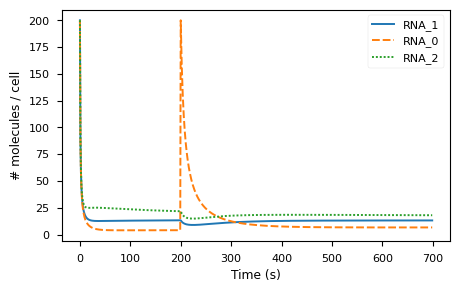

In [ ]:


chosen_circuit = circuits[4]
data_fn_ste = os.path.join(result_writer.write_dir, chosen_circuit.name, 'steady_states_data.csv')
data_fn_sig = os.path.join(result_writer.write_dir, chosen_circuit.name, 'signal_data.csv')
data = pd.concat([
    pd.read_csv(data_fn_ste, names=[s.name for s in chosen_circuit.model.species]),
    pd.read_csv(data_fn_sig, names=[s.name for s in chosen_circuit.model.species])
]).reset_index()

plt.figure(figsize=(5,3))
sns.lineplot(data[[s.name for s in set(flatten_listlike(chosen_circuit.get_input_species()))]])
plt.ylabel('# molecules / cell')
plt.xlabel('Time (s)')
plt.savefig('circ4.svg')


Log

1.
q = 5
p = 2
-> not great

2. 
q = 2
p = 5
-> good, the weak ones could be more step-like

3. 
q = 3
p = 5
-> Same-looking slope for signal, but doesn't reach as high as 2. 

4. 
q = 2
p = 10
-> better, more step-like on strong, but still a bit dragging on weaker ones

5. 
q = 2
p = 15
-> even better, more step-like, but no overshoot like you get in the no prod/deg

6. 
q = 5
p = 50
-> spiky, but now a bit too dominating with prod / deg




